In [2]:
#Show plots inline, and load main getdist plot module and samples class
### Need to run the following twice for some unknown reason. Otherwise plot wouldn't show
from __future__ import print_function
from IPython.display import display, Math
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples, loadMCSamples
import getdist, IPython
import pylab as plt
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
#matplotlib 2 doesn't seem to work well without usetex on
plt.rcParams['text.usetex']=True
import numpy as np
import WLbackground_cosmic_stds as BG
import WLlikelihoods_cosmic_stds as LIKE
import scipy.optimize as op
import emcee
from scipy import integrate
import time
from matplotlib import ticker, cm, patches, pyplot
import pandas as pd

GetDist Version: 1.1.2, Matplotlib version: 3.2.2


# Loading SNIa data:

In [7]:
pantheon_path='/Users/weikanglin/Documents/Documents NCSU/Projects/SNIa_likelihood/Pantheon_data/lcparam_full_long_zhel.txt'
pantheon0 = pd.read_csv(pantheon_path, sep=" ", header=0)
pantheon = pantheon0[['name','zcmb','mb','dmb']]
pantheon = pantheon.sort_values(by='zcmb')    # sort SNIa in a z-ascending order for the new algorithm
pantheon = pantheon.reset_index()             # have to reset the index, otherwise the index is not sorted

Npan = len(pantheon.zcmb)   # number of all SN
z_obs = pantheon.zcmb       # redshift
m_obs = pantheon.mb         # apparent magnitude
dm_obs = pantheon.dmb       # uncertainty of m

pan_sys=np.loadtxt("/Users/weikanglin/Documents/Documents NCSU/Projects/SNIa_likelihood/Pantheon_data/sys_full_long_sort.txt")   # systematic errors

C_pan = pan_sys+np.diag(pantheon.dmb**2) # including systematic errors

# Moore-Penrose pseudo-inverse
invC_pan = np.linalg.inv(C_pan)    # CHECK! In case the inverse doesn't work

# Best fits to SNIa data:

In [9]:
start_time = time.time()

nll = lambda *args: -LIKE.lnprob_SN(*args)   # load likelihood
use_fast = True      # use fast likelihood or not       
SN_data = pantheon
invC = invC_pan

result = op.minimize(nll, [24, 0.3], args=(SN_data,invC,use_fast))
MH0_best = result["x"][0]     # MH0=M-5log10(10pc*H0)  #c=1, this is the same as C in the likelihood functions
# MH0 here is a combination of H0 and the absolute magnitude shifted to zero color and zero strecth. 
Om_best = result["x"][1]
print("Best fits: %2.6f, %1.7f" % (MH0_best, Om_best))

print("--- %s seconds ---" % (time.time() - start_time))

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Best fits: 23.809306, 0.2981513
--- 2.257906198501587 seconds ---


# MCMC to SNIA data:

In [10]:
# Run the above best fits first:

ndim, nwalkers, nstep = 2, 32, 200  # settings for emcee
use_fast = True   # use the fast likelihood or not
SN_data = pantheon
invC = invC_pan

# set the path/file to save the chain:
save_chain_file = 'chains/Fast1_walkers'+str(nwalkers)+'_step'+str(nstep)+'.csv'

print("n_dim=%d, n_walker=%d, n_step=%d" % (ndim,nwalkers,nstep) )
    
# MCMC 
pos = [[MH0_best*(1+0.0004*np.random.randn()),Om_best*(1+0.01*np.random.randn())] for i in range(nwalkers)]

sampler_SN=emcee.EnsembleSampler(nwalkers, ndim, LIKE.lnprob_SN, args=(SN_data,invC,use_fast))
sampler_SN.run_mcmc(pos, nstep, progress=True,);

samples_SN = sampler_SN.chain[:, :, :].reshape((-1, ndim))   #filter out first XXX rows

np.savetxt(save_chain_file, samples_SN, delimiter=',')

n_dim=2, n_walker=32, n_step=200


100%|██████████| 200/200 [01:35<00:00,  2.10it/s]


# Caculate summary statistics:

In [11]:
load_chian_file = save_chain_file  # choose file to load
samples = np.loadtxt(load_chian_file,delimiter=",")

# Saving Median and upper and lower limits
MH0_median_low_high, Om_median_low_high = map(lambda v: ((v[1], v[2]-v[1], v[1]-v[0])), 
                           zip(*np.percentile(samples, [16, 50, 84], axis=0))) # median + upper - lower
    
# Saving means and uncertainty
MH0_mean, Om_mean = np.mean(samples,axis=0)
MH0_std, Om_std = np.std(samples,axis=0)
    
print('Median+upper-lower:')
# display median + upper -lower of C
for MEDIAN, PARAM in zip([MH0_median_low_high, Om_median_low_high], 
                         ['M-5\log_{10}(10{\\rm{pc}}\\times H_0)','\Omega_{\mathrm{m}}']):
    txt = "{3} = {{{0: 2.3f}}}^{{+{1: .3f}}}_{{-{2: .3f}}}"
    txt = txt.format(MEDIAN[0], MEDIAN[1], MEDIAN[2], PARAM)
    display(Math(txt))

# display mean+-uncertainty
print('Mean+-uncertainty:')
for MEAN, STD, PARAM in zip([MH0_mean, Om_mean], [MH0_std, Om_std],
                            ['M-5\log_{10}(10{\\rm{pc}}\\times H_0)', '\Omega_{\mathrm{m}}']):
    txt = "{2} = {0: 2.3f}\pm{1: .3f}"
    txt = txt.format(MEAN, STD, PARAM)
    display(Math(txt))

Median+upper-lower:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Mean+-uncertainty:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Removed no burn in


<Figure size 360x360 with 0 Axes>

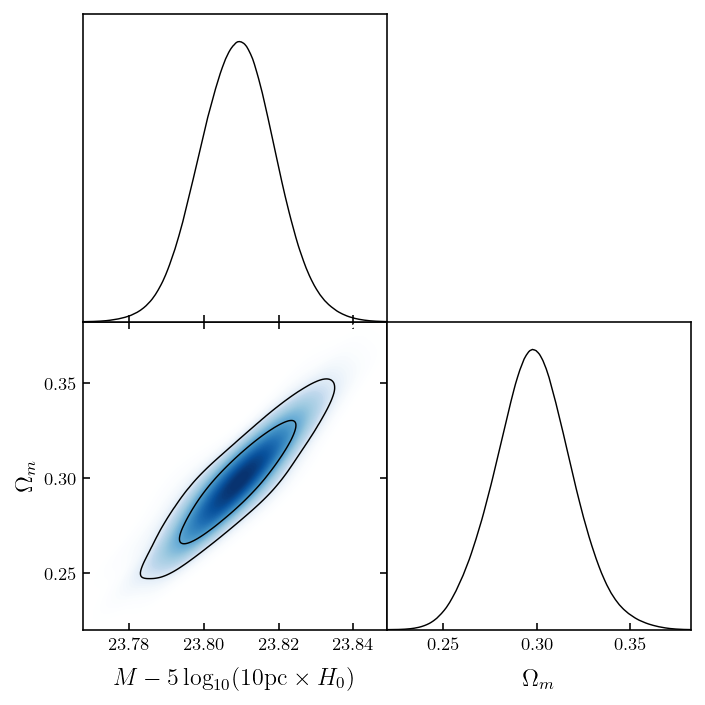

In [12]:
names = [r'MH0', 'Omegam']    # put parameters here
labels =  [r'$M-5\log_{10}(10{\rm{pc}}\times H_0)$',r'$\Omega_m$']    # label parameters here
MCsamples = MCSamples(samples=samples,names = names, labels = labels)
g = plots.getSinglePlotter(width_inch=5, ratio=1)
g.triangle_plot(MCsamples, ['MH0','Omegam'],shaded=True)
g.export(os.path.join(r'figures',r'pantheon_C_Om.pdf'))

# BAO data likelihood

# Best fit to BAO

In [13]:
start_time = time.time()

nll = lambda *args: -LIKE.lnprob_BAO(*args)   # load likelihood
BAO_data_path='BAO_data/'
BAO_datasets = ['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar','DR14p845']

result = op.minimize(nll, [0.034, 0.3], args=(BAO_data_path,BAO_datasets))
rdH0_best = result["x"][0]     # MH0=M-5log10(10pc*H0)  #c=1, this is the same as C in the likelihood functions
# MH0 here is a combination of H0 and the absolute magnitude shifted to zero color and zero strecth. 
Om_best = result["x"][1]
print("Best fits: %2.6f, %1.7f" % (rdH0_best, Om_best))

print("--- %s seconds ---" % (time.time() - start_time))

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Best fits: 0.033743, 0.2944976
--- 0.4182150363922119 seconds ---


# MCMC to BAO:

In [14]:
# Run the above best fits first:

ndim, nwalkers, nstep = 2, 64, 100  # settings for emcee
BAO_data_path='BAO_data/'
BAO_datasets = ['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar']

# set the path/file to save the chain:
save_chain_file = 'chains/BAO/BAO_walkers'+str(nwalkers)+'_step'+str(nstep)+'.csv'

print("n_dim=%d, n_walker=%d, n_step=%d" % (ndim,nwalkers,nstep) )
    
# MCMC 
pos = [[rdH0_best*(1+0.01*np.random.randn()),Om_best*(1+0.06*np.random.randn())] for i in range(nwalkers)]

sampler_BAO=emcee.EnsembleSampler(nwalkers, ndim, LIKE.lnprob_BAO, args=(BAO_data_path,BAO_datasets))
sampler_BAO.run_mcmc(pos, nstep, progress=True,);
samples_BAO = sampler_BAO.chain[:, :, :].reshape((-1, ndim))   #filter out first XXX rows

np.savetxt(save_chain_file, samples_BAO, delimiter=',')

  0%|          | 0/100 [00:00<?, ?it/s]

n_dim=2, n_walker=64, n_step=100


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


# Calculate Summary statistics:

In [15]:
load_chian_file = 'chains/BAO/BAO_walkers64_step2000.csv'  # choose file to load
samples = np.loadtxt(load_chian_file,delimiter=",")

# Saving Median and upper and lower limits
rdH0_median_low_high, Om_median_low_high = map(lambda v: ((v[1], v[2]-v[1], v[1]-v[0])), 
                           zip(*np.percentile(samples, [16, 50, 84], axis=0))) # median + upper - lower
    
# Saving means and uncertainty
rdH0_mean, Om_mean = np.mean(samples,axis=0)
rdH0_std, Om_std= np.std(samples,axis=0)
    
print('Median+upper-lower:')
# display median + upper -lower of rdH0
for MEDIAN, PARAM in zip([rdH0_median_low_high, Om_median_low_high], ['r_{\\rm{d}}H_0',
                                                                     '\Omega_{\mathrm{m}}']):
    txt = "{3} = {{{0: 2.4f}}}^{{+{1: .4f}}}_{{-{2: .4f}}}"
    txt = txt.format(MEDIAN[0], MEDIAN[1], MEDIAN[2], PARAM)
    display(Math(txt))

# display mean+-uncertainty
print('Mean+-uncertainty:')
for MEAN, STD, PARAM in zip([rdH0_mean, Om_mean], [rdH0_std, Om_std], [' r_{\\rm{d}}H_0', '\Omega_{\mathrm{m}}']):
    txt = "{2} = {0: 2.4f}\pm{1: .4f}"
    txt = txt.format(MEAN, STD, PARAM)
    display(Math(txt))

Median+upper-lower:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Mean+-uncertainty:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Plotting BAO MCMC:

Removed no burn in


<Figure size 360x360 with 0 Axes>

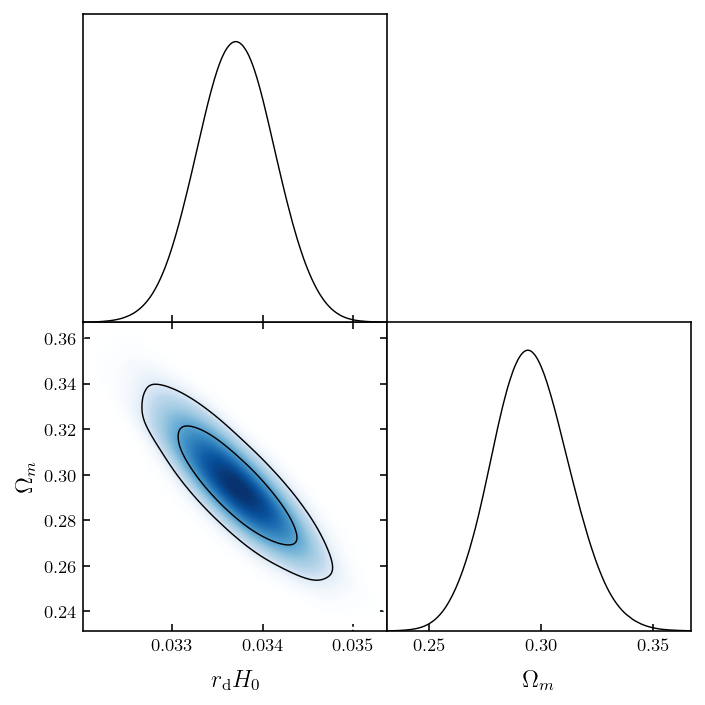

In [16]:
names = [r'rdH0', 'Omegam']    # put parameters here
labels =  [r'$r_{\rm{d}}H_0$',r'$\Omega_m$']    # label parameters here
MCsamples = MCSamples(samples=samples,names = names, labels = labels)
g = plots.getSinglePlotter(width_inch=5, ratio=1)
g.triangle_plot(MCsamples, names, shaded=True)
g.export(os.path.join(r'figures',r'BAO_rdH0_Om.pdf'))

# CMB theta:

In [17]:
# MCMC to CMB theta alone

ndim, nwalkers, nstep = 3, 64, 200  # settings for emcee
CMB_means = np.loadtxt('CMB_theta/CMB_theta_means.txt')
CMB_Cov = np.loadtxt('CMB_theta/CMB_theta_Cov.txt')
CMB_invC = np.linalg.inv(CMB_Cov)

# set the path/file to save the chain:
save_chain_file = 'CMB_theta/chains/CMB_walkers'+str(nwalkers)+'_step'+str(nstep)+'.csv'

print("n_dim=%d, n_walker=%d, n_step=%d" % (ndim,nwalkers,nstep) )
    
# MCMC 
pos = [[1089*(1+0.001*np.random.randn()),
        0.03307*(1+0.01*np.random.randn()),0.3*(1+0.01*np.random.randn())] for i in range(nwalkers)]

sampler_CMB=emcee.EnsembleSampler(nwalkers, ndim, LIKE.lnprob_CMB, args=(CMB_means,CMB_invC))
sampler_CMB.run_mcmc(pos, nstep, progress=True,);
samples_CMB = sampler_CMB.chain[:, :, :].reshape((-1, ndim))   #filter out first XXX rows

np.savetxt(save_chain_file, samples_CMB, delimiter=',')

  0%|          | 0/200 [00:00<?, ?it/s]

n_dim=3, n_walker=64, n_step=200


100%|██████████| 200/200 [00:14<00:00, 14.06it/s]


Removed no burn in


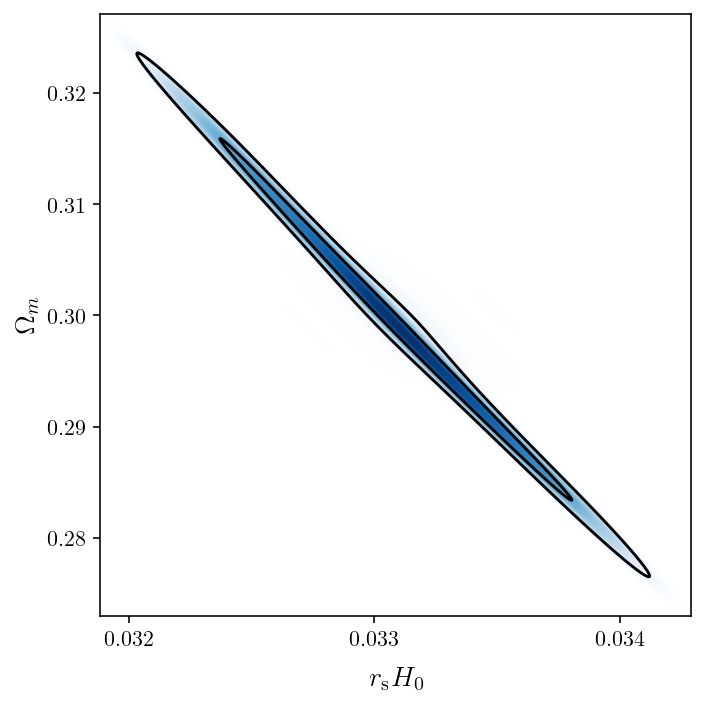

In [18]:
load_chian_file = save_chain_file  # choose file to load
samples = np.loadtxt(load_chian_file,delimiter=",")
names = ['zstar','rsH0', 'Omegam']    # put parameters here
labels =  [r'$z_*$',r'$r_{\rm{s}}H_0$',r'$\Omega_m$']    # label parameters here
MCsamples = MCSamples(samples=samples,names = names, labels = labels)
g = plots.getSinglePlotter(width_inch=5, ratio=1)
g.plot_2d([MCsamples], 'rsH0', 'Omegam', shaded=True)
g.export(os.path.join(r'figures',r'CMB_rsH0_Om.pdf'))

# Combined analysis:

In [20]:
pantheon_path='/Users/weikanglin/Documents/Documents NCSU/Projects/SNIa_likelihood/Pantheon_data/lcparam_full_long_zhel.txt'
pantheon0 = pd.read_csv(pantheon_path, sep=" ", header=0)
pantheon = pantheon0[['name','zcmb','mb','dmb']]
pantheon = pantheon.sort_values(by='zcmb')    # sort SNIa in a z-ascending order for the new algorithm
pantheon = pantheon.reset_index()             # have to reset the index, otherwise the index is not sorted
Npan = len(pantheon.zcmb)   # number of all SN
pan_sys=np.loadtxt("/Users/weikanglin/Documents/Documents NCSU/Projects/SNIa_likelihood/Pantheon_data/sys_full_long_sort.txt")   # systematic errors
C_pan = pan_sys+np.diag(pantheon.dmb**2) # including systematic errors
invC_pan = np.linalg.inv(C_pan)

BAO_data_path='BAO_data/'
BAO_datasets = ['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar','DR14p845']

CMB_means = np.loadtxt('CMB_theta/CMB_theta_means.txt')
CMB_Cov = np.loadtxt('CMB_theta/CMB_theta_Cov.txt')
CMB_invC = np.linalg.inv(CMB_Cov)

In [155]:
# Define the combined likelihoods

def lnprior_combined(theta): # keep the order of theta to be zstar, rsH0, MH0, Om, h, and m_v1
    if len(theta)==5:
        if 1070<theta[0]<1120 and 0.01<theta[1]<0.1 and 17<theta[2]<30 and 0.01<theta[3]<0.99 and 0.55<theta[4]<0.88:
            return 0.0
    if len(theta)==6:
        if 1070<theta[0]<1120 and 0.01<theta[1]<0.1 and 17<theta[2]<30 and 0.01<theta[3]<0.99 and 0.55<theta[4]<0.88 and 0.0002<theta[5]<1.0:
            return 0.0
    return -np.inf

def lnprob_stds(theta,SN_input,BAO_input,CMB_input):
    SN_data, invC = SN_input   # use fast SN likelihood by default
    BAO_data_path, BAO_datasets = BAO_input
    CMB_means, CMB_invC = CMB_input
    if len(theta)==5:
        zstar_fit, rsH0_fit, MH0_fit, Om_fit, h_fit = theta
        m_v1_fit=0.0
        rdH0_derived = rsH0_fit+BG.Delta_rH0(zstar_fit,29.98,Om_fit,h_fit) 
        # Deltaz is set to be 29.98, need further consideration
        theta_SN = [MH0_fit, Om_fit, h_fit]
        theta_BAO = [rdH0_derived, Om_fit, h_fit]
        theta_CMB = [zstar_fit, rsH0_fit, Om_fit, h_fit]
    if len(theta)==6:
        zstar_fit, rsH0_fit, MH0_fit, Om_fit, h_fit, m_v1_fit = theta
        rdH0_derived = rsH0_fit+BG.Delta_rH0(zstar_fit,29.98,Om_fit,h_fit,m_v1_fit) 
        theta_SN = [MH0_fit, Om_fit, h_fit, m_v1_fit]
        theta_BAO = [rdH0_derived, Om_fit, h_fit, m_v1_fit]
        theta_CMB = [zstar_fit, rsH0_fit, Om_fit, h_fit, m_v1_fit]
        
    lp = lnprior_combined(theta)
    if not np.isfinite(lp):
        return -np.inf
    lp += LIKE.lnlike_SN_fast(theta_SN, SN_data, invC)
    lp += LIKE.lnlike_BAO(theta_BAO, BAO_data_path, BAO_datasets)
    lp += LIKE.lnlike_CMB(theta_CMB, CMB_means, CMB_invC)
    return lp
    

# Combined MCMC

In [156]:
ndim, nwalkers, nstep = 5, 32, 500  # settings for emcee
# set the path/file to save the chain:
save_chain_file = 'chains/UCstds'+str(nwalkers)+'_step'+str(nstep)+'.csv'

print("n_dim=%d, n_walker=%d, n_step=%d" % (ndim,nwalkers,nstep) )

SN_input=[pantheon,invC_pan]
BAO_input= ['BAO_data/',['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar','DR14p845']]
CMB_input= [CMB_means,CMB_invC]

# MCMC 
pos = [[1089.9515*(1+0.0002*np.random.randn()),
        0.03243*(1+0.01*np.random.randn()),
        23.809306*(1+0.0003*np.random.randn()),
        0.3037*(1+0.044*np.random.randn()),
                 0.75*(1+0.2*np.random.randn())] for i in range(nwalkers)]

sampler_combined=emcee.EnsembleSampler(nwalkers, ndim, lnprob_stds, args=(SN_input,BAO_input,CMB_input))
sampler_combined.run_mcmc(pos, nstep, progress=True,);

samples_combined = sampler_combined.chain[:, 50:, :].reshape((-1, ndim))   #filter out first XXX rows

np.savetxt(save_chain_file, samples_combined, delimiter=',')

n_dim=5, n_walker=32, n_step=500


  0%|          | 0/500 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [05:12<00:00,  1.60it/s]


Removed no burn in


<Figure size 576x576 with 0 Axes>

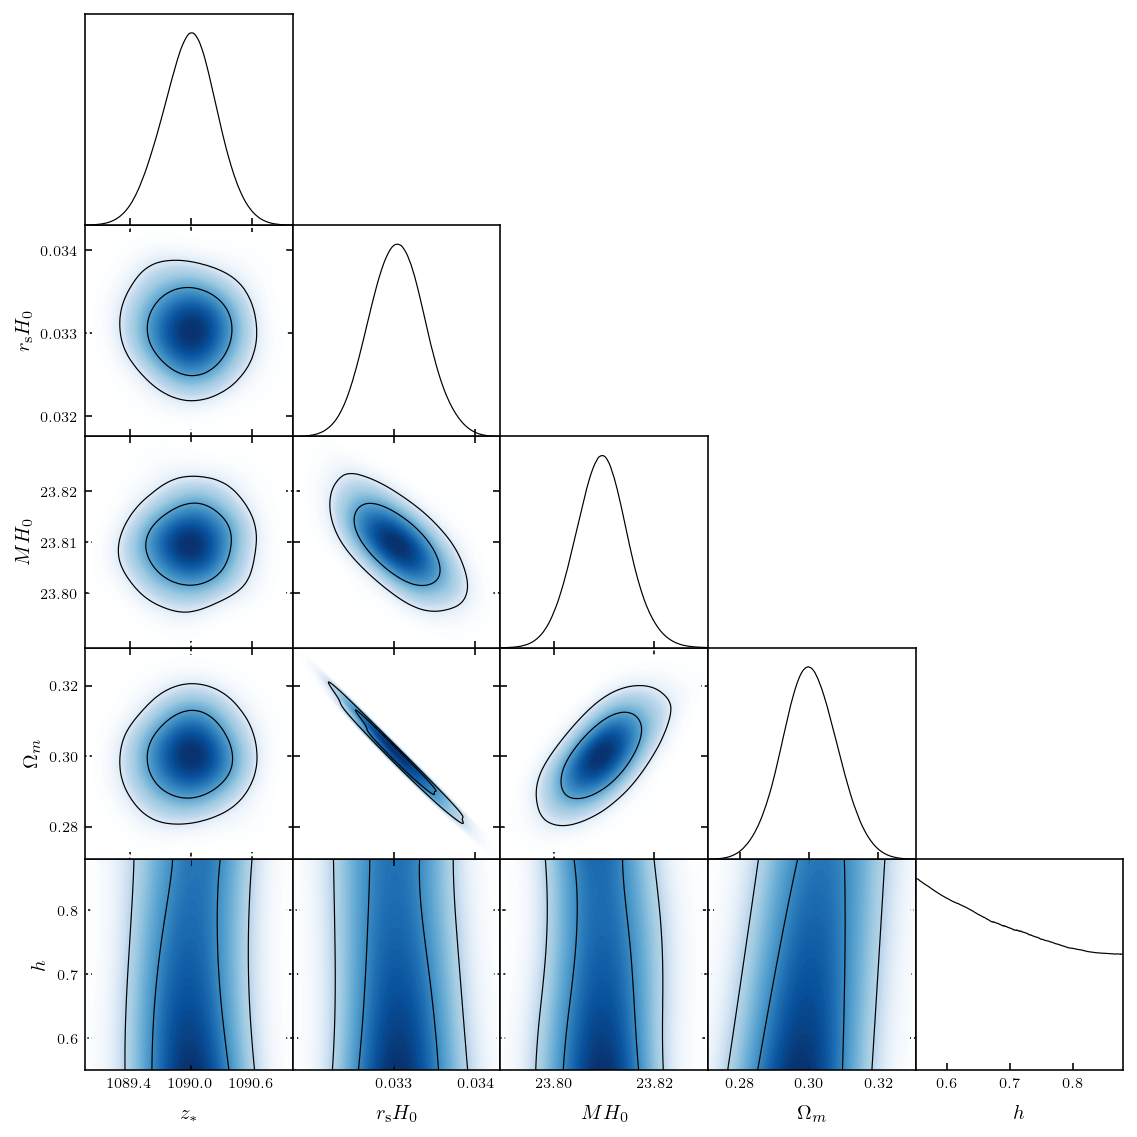

In [157]:
load_chian_file = save_chain_file # choose file to load
samples = np.loadtxt(load_chian_file,delimiter=",")
names = ['zstar','rsH0', 'MH0','omegam','h']    # put parameters here
labels =  [r'$z_*$',r'$r_{\rm{s}}H_0$',r'$MH_0$',r'$\Omega_m$',r'$h$']    # label parameters here
MCsamples = MCSamples(samples=samples,names = names, labels = labels,ranges={'h':(0.55, 0.88)},
                      label='Uncalibrated Cosmic Standards')
p = MCsamples.getParams() 
MCsamples.addDerived(p.h*100, name='H0', label=r'$H_0$',range=[55,88])
g = plots.getSinglePlotter(width_inch=8, ratio=1)
g.triangle_plot(MCsamples, names, shaded=True)
g.export(os.path.join(r'figures',r'Combined.pdf'))

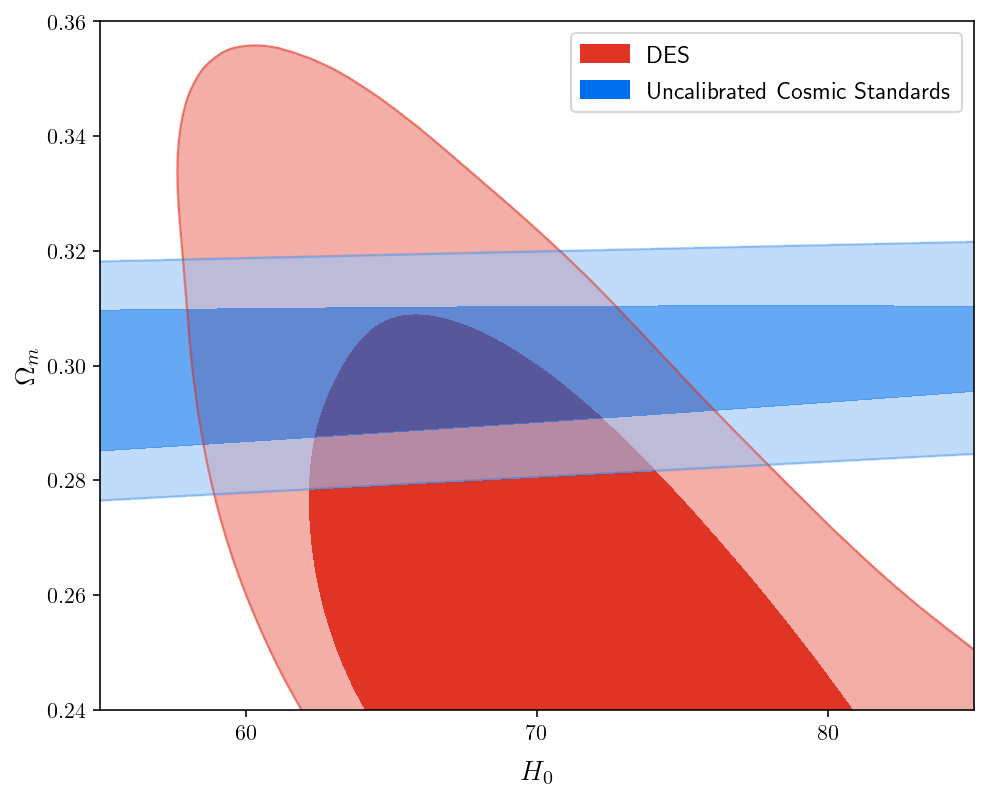

In [158]:
tempdir='/Users/weikanglin/Documents/Documents NCSU/Projects/3STDs/chains_LSS/DES_withBBN'
g = plots.getSinglePlotter(chain_dir=tempdir,width_inch=7, ratio=0.8)
g.settings.alpha_filled_add=0.6
samples_DES = loadMCSamples(tempdir, settings={'ignore_rows':0.3}); 
g.plot_2d([samples_DES,MCsamples], 'H0', 'omegam',filled=True)

# preliminary:
#g.add_2d_covariance(np.array([72.4626984 ,  0.29842372]), 
#                    np.array([[4.68442296e+01, 1.10692999e-03],[1.10692999e-03, 6.61706597e-05]]),
#                    filled=True, color='g',alpha=0.75)

g.add_legend(['DES','Uncalibrated Cosmic Standards', 'Preliminary Joint'])
g.set_axes(lims=[55, 85, 0.24, 0.36])


g.export(os.path.join(r'figures',r'Combined_h_Om_new.pdf'))

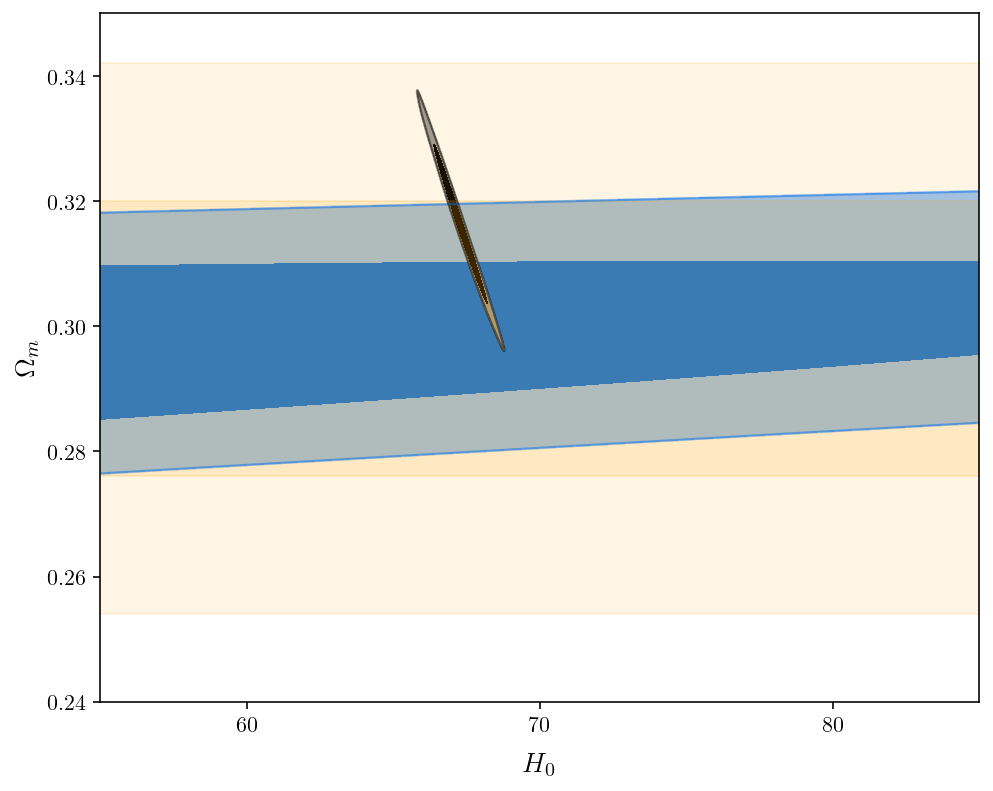

In [159]:
g = plots.getSinglePlotter(width_inch=7, ratio=0.8)
g.settings.alpha_filled_add=0.5
g.plot_2d([MCsamples], 'H0', 'omegam',filled=True)
g.add_y_bands(0.298, 0.022,color='orange')
#g.add_y_bands(0.2954, 0.0175,color='r')
g.add_2d_contours('/Users/weikanglin/Documents/Documents NCSU/Projects/3STDs/chains_new/base_plikHM_TTTEEE_lowl_lowE', 'H0', 'omegam',
                  filled=True, color='k');

g.set_axes(lims=[55, 85, 0.24, 0.35])

In [134]:
# Saving Median and upper and lower limits
# Saving means and uncertainty

load_chian_file = save_chain_file # choose file to load
samples_all_rulers = np.loadtxt(load_chian_file,delimiter=",")
names = ['zstar','rsH0', 'MH0','omegam','h']    # put parameters here
labels =  [r'$z_*$',r'$r_{\rm{s}}H_0$',r'$MH_0$',r'$\Omega_m$',r'$h$']    # label parameters here
MCsamples_UCrulers = MCSamples(samples=samples,names = names, labels = labels,ranges={'h':(None, 2)},
                      label='Uncalibrated Standard Rulers')
p = MCsamples_UCrulers.getParams() 
MCsamples_UCrulers.addDerived(p.h*100, name='H0', label=r'$H_0$')

MEANS = np.mean(samples,axis=0)
ERRORS = np.std(samples,axis=0)
    
print('Median+upper-lower:')

# display mean+-uncertainty
print('Mean+-uncertainty:')
for MEAN, STD, PARAM in zip(MEANS, ERRORS, [r'z_*',r'r_{\rm{s}}H_0',
                                            r'M-5\log_{10}(10{\rm{pc}}\times H_0)',r'\Omega_m',r'h']):
    txt = "{2} = {0: 2.4f}\pm{1: .4f}"
    txt = txt.format(MEAN, STD, PARAM)
    display(Math(txt))

Removed no burn in
Median+upper-lower:
Mean+-uncertainty:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
CMB_means = np.loadtxt('CMB_theta/CMB_theta_means.txt')
CMB_Cov = np.loadtxt('CMB_theta/CMB_theta_Cov.txt')
CMB_invC = np.linalg.inv(CMB_Cov)

SN_input=[pantheon,invC_pan]
BAO_input= ['BAO_data/',['6df','DR7_MGS','DR12_consensus','DR14_qsar','DR14_lya_qsar']]
CMB_input= [CMB_means,CMB_invC]
lnprob_stds([1089.9515,0.03243,23.809306,0.3,0.70],SN_input,BAO_input,CMB_input)